In [1]:
import pandas as pd

df = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
df.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


Text(0, 0.5, 'Salary')

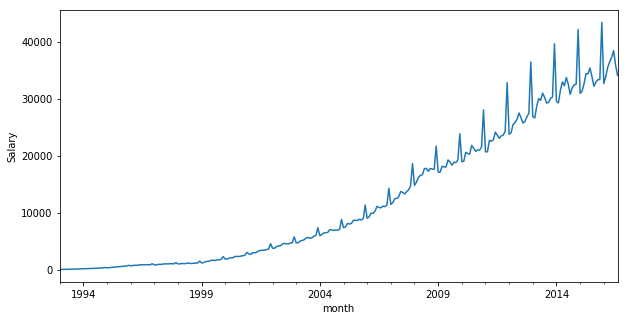

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,5))
df.WAG_C_M.plot()
plt.ylabel('Salary')

Критерий Дики-Фуллера: 0.9918495954854734


<Figure size 432x288 with 0 Axes>

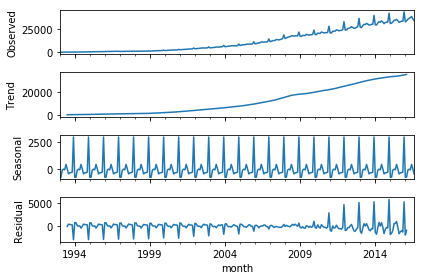

In [24]:
import statsmodels.api as sm

plt.figure()
sm.tsa.seasonal_decompose(df.WAG_C_M).plot()
print('Критерий Дики-Фуллера: {}'.format(sm.tsa.stattools.adfuller(df.WAG_C_M)[1]))

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


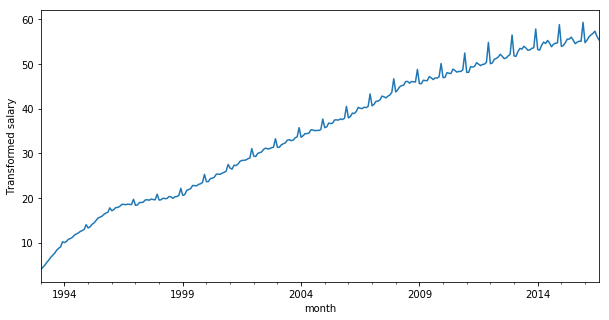

In [25]:
import numpy as np
from scipy import stats

df['log_WAG_C_M'], lmbda = stats.boxcox(df['WAG_C_M'])
plt.figure(figsize=(10,5))
df.log_WAG_C_M.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['log_WAG_C_M'])[1])

Критерий Дики-Фуллера: 0.014697133494791847


<Figure size 720x360 with 0 Axes>

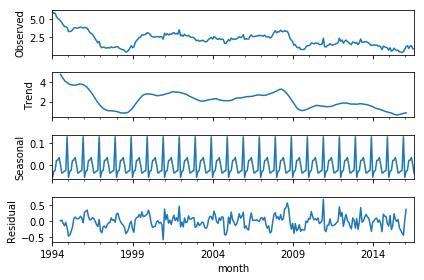

In [29]:
df['log_WAG_C_M_diff'] = df.log_WAG_C_M - df.log_WAG_C_M.shift(12)
plt.figure(figsize=(10,5))
sm.tsa.seasonal_decompose(df.log_WAG_C_M_diff[12:]).plot()
print('Критерий Дики-Фуллера: {}'.format(sm.tsa.stattools.adfuller(df.log_WAG_C_M_diff[12:])[1]))

Критерий Дики-Фуллера: 5.20360371582143e-08


<Figure size 1440x720 with 0 Axes>

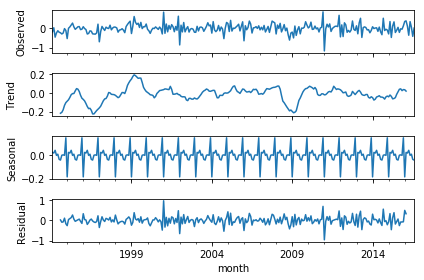

In [30]:
df['log_WAG_C_M_diff2'] = df.log_WAG_C_M_diff - df.log_WAG_C_M_diff.shift(1)
plt.figure(figsize=(20,10))
sm.tsa.seasonal_decompose(df.log_WAG_C_M_diff2[13:]).plot()
print('Критерий Дики-Фуллера: {}'.format(sm.tsa.stattools.adfuller(df.log_WAG_C_M_diff2[13:])[1]))

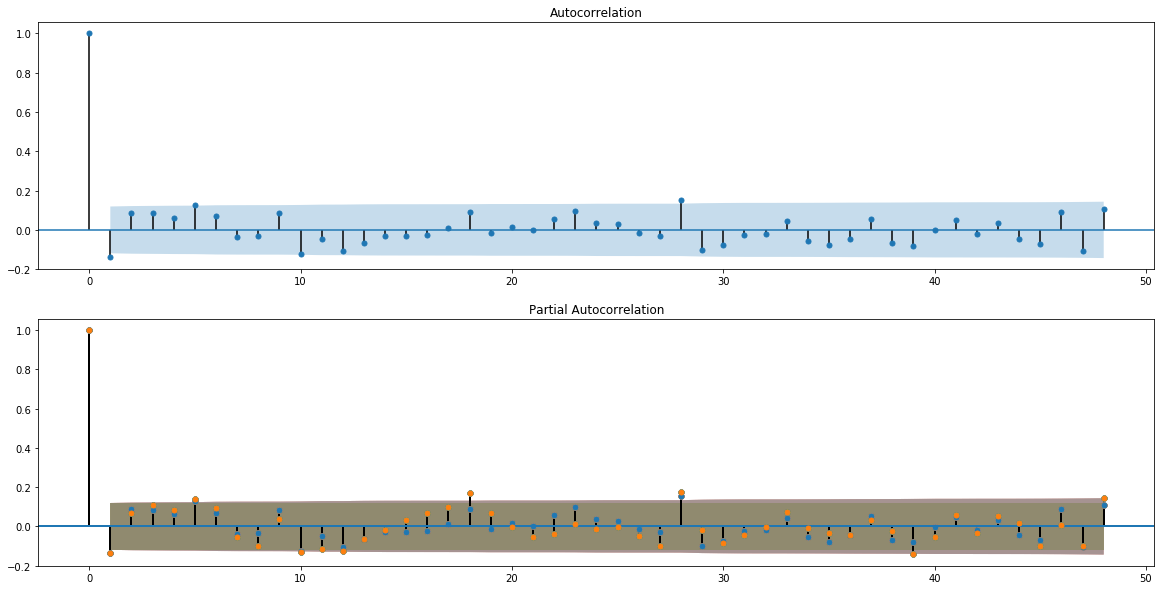

In [58]:
sm.graphics.tsa.plot_acf(df.log_WAG_C_M_diff2[13:].values.squeeze(), lags=48, ax=ax)
sm.graphics.tsa.plot_pacf(df.log_WAG_C_M_diff2[13:].values.squeeze(), lags=48, ax=ax)

In [57]:
ps = range(0, 7)
d=1
qs = range(0, 7)
Ps = range(0, 2)
D=1
Qs = range(0, 1)
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

98

wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 4, 1, 0)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 2, 1, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (5, 4, 0, 0)
wrong parameters: (5, 4, 1, 0)
wrong parameters: (6, 3, 0, 0)
wrong parameters: (6, 3, 1, 0)
wrong parameters: (6, 4, 0, 0)
wrong parameters: (6, 4, 1, 0)
      parameters        aic
63  (5, 5, 1, 0) -25.193215
55  (4, 5, 1, 0) -24.902990
57  (4, 6, 1, 0) -24.481086
73  (6, 5, 1, 0) -22.624946
62  (5, 5, 0, 0) -22.267415
                                 Statespace Model Results                                 
Dep. Variable:                        log_WAG_C_M   No. Obs

Text(0, 0.5, 'WAG_C_M')

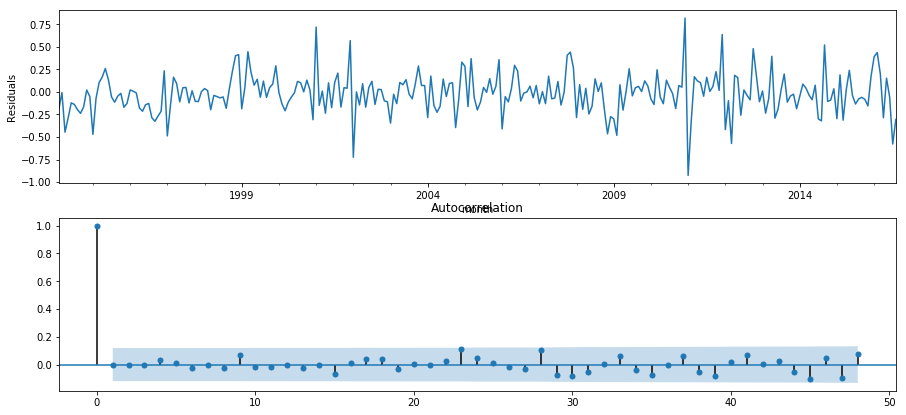

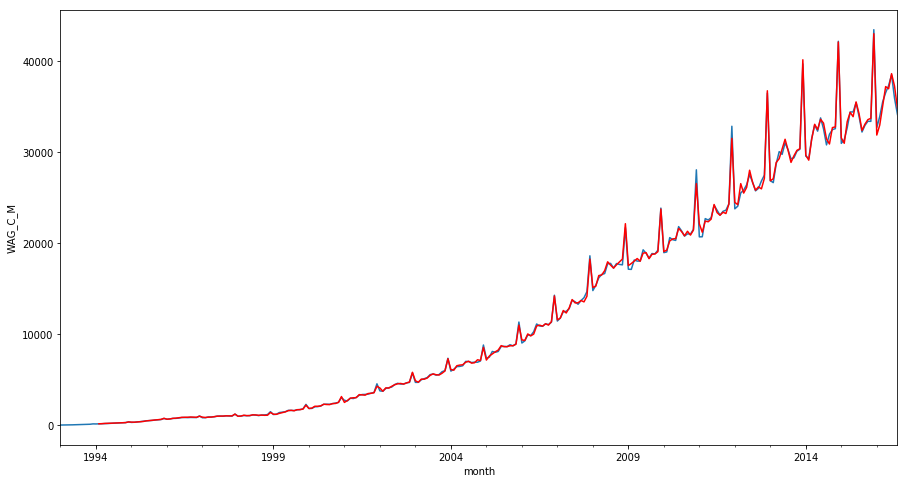

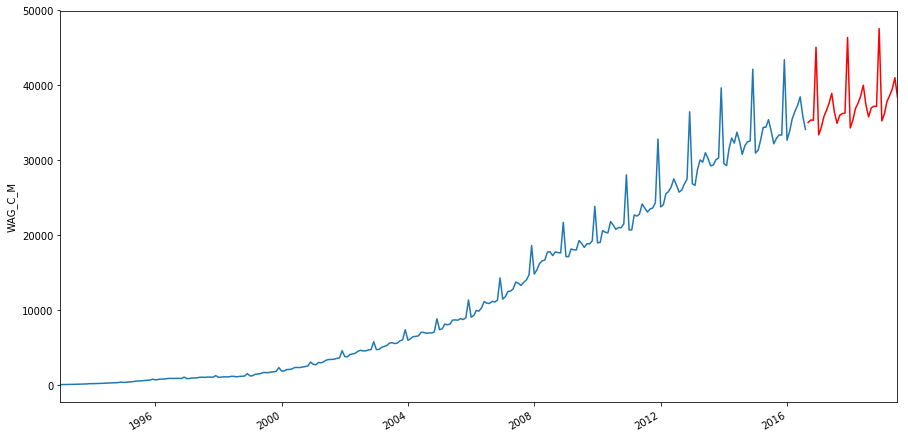

In [61]:

import warnings
import datetime
from dateutil.relativedelta import relativedelta
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.log_WAG_C_M, order=(param[0], d, param[1]), \
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

print(best_model.summary())
#warnings.filterwarnings('default')

plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print('Критерий Стьюдента: {}'.format(stats.ttest_1samp(best_model.resid[13:], 0)[1]))
print('Критерий Дики-Фуллера: {}'.format(sm.tsa.stattools.adfuller(best_model.resid[13:])[1]))



def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1) / lmbda))

df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,8))
df.WAG_C_M.plot()
df.model[13:].plot(color='r')
plt.ylabel('WAG_C_M')

df2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=284, end=319), lmbda)

plt.figure(figsize=(15,8))
df2.WAG_C_M.plot()
df2.forecast.plot(color='r')
plt.ylabel('WAG_C_M')
